<a href="https://colab.research.google.com/github/TheAcoff/Notebook-Alura/blob/main/Redes_Neurais/RN_Crua_com_TF_Doen%C3%A7as_Card%C3%ADacas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doenças Cardíacas, Previsão com Redes Neurais
Nesse trabalho, será desenvovida uma rede neural usando TensorFlow no baixo nível, podendo ter controle total dos parâmetros utilizados na construção.

## Dados

Instalação da biblioteca que puxa os dados

In [132]:
!pip install ucimlrepo

Podemos então baixar nossa base de dados e ver todas as variáveis

In [133]:
from ucimlrepo import fetch_ucirepo

doenca_cardiaca = fetch_ucirepo(id=45)
print('Variáveis disponíveis no dataset de doenças cardíacas da UCI:')
doenca_cardiaca.variables

Variáveis disponíveis no dataset de doenças cardíacas da UCI:


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


Escolhemos três características para o nosso modelo:
- Idade (age)
- Nível de colesterol (chol)
- Dor no peito (cp)

In [134]:
X = doenca_cardiaca.data.features
X = X[['age','chol','cp']]

X.head()

,age,chol,cp
0,63,233,1
1,67,286,4
2,67,229,4
3,37,250,3
4,41,204,2


Puxamos também os resultados:

In [135]:
Y = doenca_cardiaca.data.targets
Y.head()

,num
0,0
1,2
2,1
3,0
4,0


Verificando os valores existentes no target, encontramos:

In [136]:
Y['num'].unique()

array([0, 2, 1, 3, 4])

Podemos converter os valores para uma forma binária, para caso teve o problema ou não

In [137]:
Y = (Y>0)*1
Y.head()

,num
0,0
1,1
2,1
3,0
4,0


E assim construímos o nosso conjunto de dados

In [138]:
dados = X.copy()
dados['y'] = Y
dados.head()

,age,chol,cp,y
0,63,233,1,0
1,67,286,4,1
2,67,229,4,1
3,37,250,3,0
4,41,204,2,0


### Análise Exploratória
Com os dados tratados, podemos fazer uma análise preliminar dos dados

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

Primeiramente, veremos a relação entre idades dos pacientes e se tiveram doença cardíaca (y = 1) ou não (y = 0).

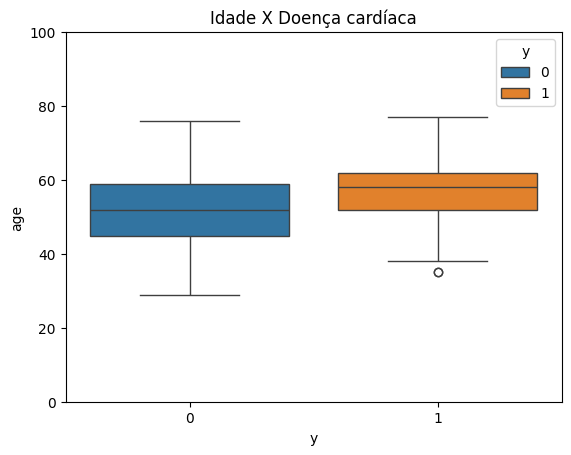

In [140]:
sns.boxplot(x='y', y='age', hue='y', data=dados)
plt.title('Idade X Doença cardíaca')
plt.ylim(0, 100)
plt.show()

O mesmo pode ser feito para o nível de colesterol

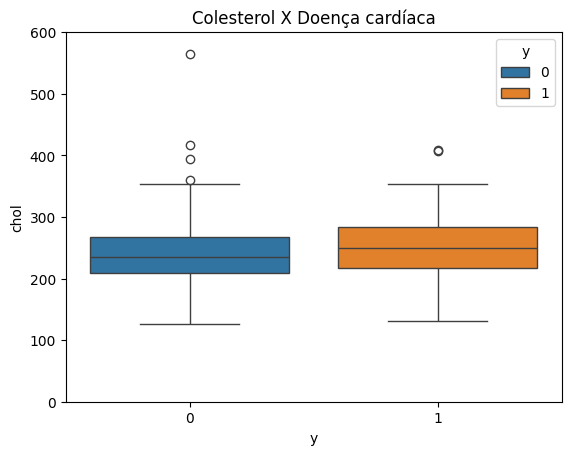

In [141]:
sns.boxplot(x='y', y='chol', hue='y', data=dados)
plt.title('Colesterol X Doença cardíaca')
plt.ylim(0,600)
plt.show()

Com os dados em mãos, podemos analisar a correlação das variáveis

<Axes: >

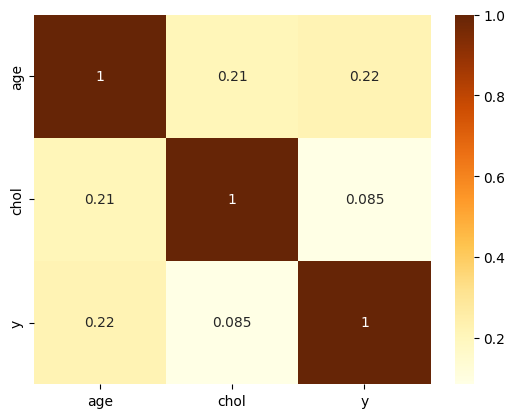

In [142]:
corr = dados[['age','chol','y']].corr()

sns.heatmap(corr,cmap = 'YlOrBr',annot=True)

### Preparando os resultados
Agora, podemos transformar `cp` em variáveis dummies, multiplicando as colunas para os tipos diferentes

In [143]:
import pandas as pd
df_cp = pd.get_dummies(X['cp'], prefix='cp', dtype=int)
df_cp.head()

,cp_1,cp_2,cp_3,cp_4
0,1,0,0,0
1,0,0,0,1
2,0,0,0,1
3,0,0,1,0
4,0,1,0,0


Agora, substituímos no conjunto de dados

In [144]:
X = X.drop('cp', axis = 1).join(df_cp)
X.head()

,age,chol,cp_1,cp_2,cp_3,cp_4
0,63,233,1,0,0,0
1,67,286,0,0,0,1
2,67,229,0,0,0,1
3,37,250,0,0,1,0
4,41,204,0,1,0,0


---

## Neurônio Perceptron
As redes neurais possuem uma estrutura básica chamada neurôinio. Se observarmos essa estrutura, elas possuem algumas variáveis integradas a elas:
- Pesos
- Bias
- Função de Ativação

Os neurônios são separados em camadas, e todas essas camadas possuem nomes conhecidos.
- Input Layer
- Hidden Layer
- Output Layer

Para uma camada com neurônios ($a^{l}$), temos que receber valores de uma camada anterior ($a^{l-1}$). Esses valores irão primeiramente ser passados por uma função de ativação $\sigma(x)$

$$
a^{l}_{j} = \sigma\left(\sum\limits_{k} \omega^{l}_{jk} a^{l-1}_{k} + b^{l}_{j} \right)
$$

em que $\omega$ são os pesos e $b$ são o bias. Esses valores vão sendo percorridos até chegar à camada de saída. Esse processo é chamado de *feed forward*

Começamos a nossa rede definindo a seed de aleatoriedade, tornando os resultados reprodutíveis

In [145]:
import tensorflow as tf
seed = 31
tf.random.set_seed(seed)
print(f'TensorFlow importado na versão {tf.__version__} com a seed {seed}')

TensorFlow importado na versão 2.17.0 com a seed 31


Começamos iniciando os pesos e os víeses

In [146]:
peso = tf.Variable(tf.random.normal([1], name = 'peso'))
vies = tf.Variable(tf.random.normal([1], name = 'vies'))

print(f'Peso inicial: {peso.numpy()}')
print(f'Vies inicial: {vies.numpy()}')

Peso inicial: [-0.3594139]
Vies inicial: [0.15100643]


Agora podemos iniciar o neurônio. Usaremos como função de ativação a sigmoid. A função sigmoid vai ajudar a normalizar as saídas

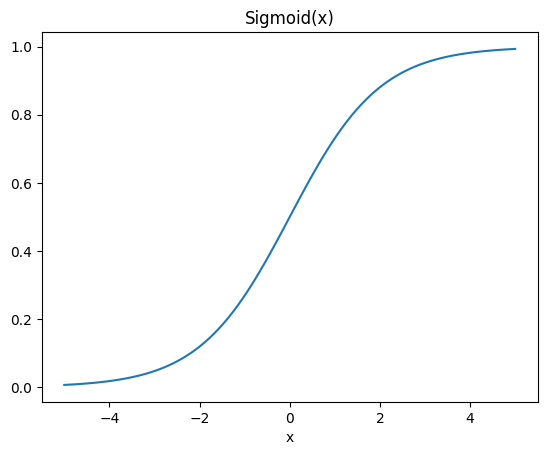

In [147]:
import numpy as np

x = np.linspace(-5,5,100)
y = tf.sigmoid(x)
plt.plot(x,y)
plt.xlabel('x')
plt.title('Sigmoid(x)')
plt.show()

In [148]:
def neuronio(x):
  return tf.sigmoid(tf.add(tf.multiply(peso,x),vies))

Podemos fazer um exemplo simples de resultado de um neurônio que recebe um número 10 como entrada

In [149]:
exemplo = tf.constant(10.0)
resultado = neuronio(exemplo)
print(f'Resultado do neurônio: {resultado.numpy()}')

Resultado do neurônio: [0.03097433]


### Usando os dados
Podemos aplicar uma coluna dos dados no neurônio para obter algumas respostas. Supondo que um resultado maior que 0.5 seja um valor verdadeiro

In [150]:
def teste(x):
  return neuronio(x)>0.5

In [151]:
teste(exemplo)

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([False])>

Agora, usaremos a nossa coluna de dados de colesterol e mostraremos apenas alguns valores

In [152]:
respostas = teste(tf.constant(X['chol'],dtype=tf.float32)).numpy()
respostas_df = pd.DataFrame(respostas,columns=['respostas'])
respostas_df.value_counts()

,count
respostas,
False,303


Pela aleatoriedade dos nossos pesos, vemos que todos os dados foram falsos. Agora, temos que descobrir como podemos mostrar pra rede neural se os valores dos pesos e vieses estão adequados ou não.

### Perda (loss)
Toda rede neural deve ter um critério de loss para ser usado como base no aprendizado, aí, a rede irá adaptar os valores dos pesos e vieses, aproximando do resultado esperado. Começamos transformando nossas respostas corretas para comparação em um tensor.

In [153]:
y = tf.constant(Y['num'], dtype=tf.float32)
y[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 0., 1., 0., 1., 1.], dtype=float32)>

Vamos calcular nossa perda, para isso usaremos a Binary Cross Entropy:
$$
\text{loss} = - \frac{1}{N} \sum_{i=1}^{N} y_i \cdot \log(p(y_i)) + (1-y_i) \cdot \log(1-p(y_i))
$$

Nos parâmetros, passamos os dados verdadeiros e os dados que o neurônio preveu

In [154]:
calculo_perda = tf.keras.losses.BinaryCrossentropy()
perda = calculo_perda(y_true = y, y_pred=respostas)
print(f'Perda: {perda.numpy()}')

Perda: 7.39410924911499


### Acurácia
Agora, para a acurácia, calculamos o quanto o neurônio acertou fazendo uma média de todos os resultados

In [155]:
np.mean(y.numpy() == respostas*1) #*1 para transformar Ture para 1 e False para 0

0.5412541254125413

Para um problema médico, 54% de acurácia é considerado baixo. Vamos expplorar algumas estratégias para melhorar isso. Mas antes, faremos o teste para a coluna ch_1.

In [156]:
print('Resultados para coluna ch_1: \n')

respostas = teste(tf.constant(X['cp_1'],dtype=tf.float32)).numpy()
respostas_df = pd.DataFrame(respostas,columns=['respostas'])
print(respostas_df.value_counts())
print('==='*15)

calculo_perda = tf.keras.losses.BinaryCrossentropy()
perda = calculo_perda(y_true = y, y_pred=respostas)
print(f'Perda: {perda.numpy()}')
print('==='*15)

acuracia = np.mean(y.numpy() == respostas*1)
print(f'Acurácia: {acuracia}')

Resultados para coluna ch_1: 

respostas
True         280
False         23
Name: count, dtype: int64
Perda: 8.159404754638672
Acurácia: 0.4884488448844885


# Modelo Completo Com Um Neurônio
Lembrando dos elementos, temos os dados de entrada em `X` e as respostas corretas em `y`.

O primeiro passo vai ser normalizar os dados usando o StandardScaler, que irá normalizar com a média = 0 e desvio padrão = 1

In [157]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [158]:
X[['age','chol']] = scaler.fit_transform(X[['age','chol']])
print('Primeiros Valores')
X[['age','chol']].head()

Primeiros Valores


,age,chol
0,0.948726,-0.264900
1,1.392002,0.760415
2,1.392002,-0.342283
3,-1.932564,0.063974
4,-1.489288,-0.825922


Com os dados normalizados, podemos construir nosso neurônio. Ele irá receber uma linha de cada vez. Vamos verificar quantos dados temos de entrada em cada linha e construir o neurônio a partir daí.

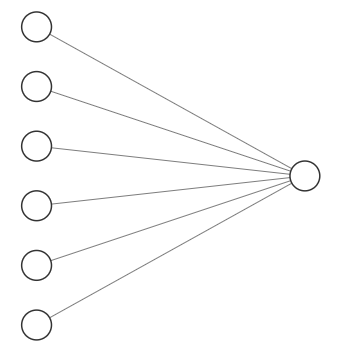

In [159]:
X.shape[1]

6

In [160]:
tamanho = X.shape[1]
peso = tf.Variable(tf.random.normal([tamanho,1], name = 'peso'))
vies = tf.Variable(tf.random.normal([1]))

Construindo o neurônio, lembrando que agora estamos trabalhando com matrizes

In [161]:
def neuronio(x):
  return tf.sigmoid(tf.add(tf.matmul(x, peso), vies)) # matmul para multiplicar matrizes

Fazendo o teste com o primeiro paciente

In [162]:
neuronio(tf.constant(X.iloc[0].values, dtype=tf.float32, shape = (1,6)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9289319]], dtype=float32)>

Isso retornaria um valor verdadeiro! Vamos jogar todos os pacientes

In [163]:
entrada = tf.constant(X, dtype=tf.float32)
resultado = neuronio(entrada)
resultado[:10].numpy()

array([[0.9289319 ],
       [0.14875948],
       [0.56224597],
       [0.42359152],
       [0.49607018],
       [0.3407665 ],
       [0.21874033],
       [0.0116465 ],
       [0.3205164 ],
       [0.6717675 ]], dtype=float32)

Podemos agora avaliar o modelo

In [164]:
perda = calculo_perda(y_true = y, y_pred = resultado)
print(f'Perda: {perda.numpy()}')
print(f'==='*15)

acuracia = np.mean(y.numpy() == (resultado.numpy() > 0.5)*1)
print(f'Acuracia: {acuracia}')

Perda: 1.1875790357589722
Acuracia: 0.5036761101852759


## Gradiente Descendente
Para ajustar os pesos e vieses, tendo em mente a diminuição do loss, temos que achar o custo mínimo. Para isso, usamos o gradiente da função. O algorítimo funcionará com as seguintes etapas:

1. Inicializamos os pesos aleatoriamente
2. Calculamos o gradiente em função de cada parâmetro.
3. Atualizamos o parâmetro

Esse processo é chamado de Backpropagation. Considerando os pesos como $\omega$ e os vieses como $b$, e a função custo como $C$ atualizamos os parâmetros com um uma taxa de aprendizado $\eta$

$$
\begin{aligned}
\omega_{k} \rightarrow \omega_{k}' = \omega_{k} - \eta\frac{\partial C}{\partial \omega_{k}} \\
b_{l} \rightarrow b_{l}' = b_l - \eta\frac{\partial C}{\partial b_{l}}
\end{aligned}
$$

In [165]:
tamanho = X.shape[1]
peso = tf.Variable(tf.random.normal([tamanho,1], name = 'peso'))
vies = tf.Variable(tf.random.normal([1]))

def neuronio(x):
  return tf.sigmoid(tf.add(tf.matmul(x, peso), vies))

In [166]:
learning_rate = 0.01

otimizador = tf.optimizers.SGD(learning_rate = learning_rate)

Para facilitar a execução, reiniciamos os pesos e vieses

Definimos quantas vezes o código será executado como epocas (epochs). Armazenamos todos os dados do gradiente em uma "fita"

In [167]:
import time
epochs = 1000

#Tempo de execução
tic = time.time()

for epoch in range(epochs):
  # Marcar tempo de início
  # Armazenando os dados
  with tf.GradientTape() as tape:
    resultado = neuronio(entrada)
    loss = calculo_perda(y_true=y, y_pred=resultado)

  # Pegando os gradientes
  gradientes = tape.gradient(loss, [peso, vies])
  #Aplicando os gradientes no otimizador SGD
  otimizador.apply_gradients(zip(gradientes, [peso, vies]))

  #Criando um callout para reduzir o número de saídas
  if (epoch + 1) % 100 == 0: #se o resto da divisão por 100 == 0
    print(f'Epoch: {epoch+1}, loss: {loss.numpy()}')

tac = time.time()
tempo = (tac - tic)

acuracia = np.mean(y.numpy() == (resultado.numpy()>0.5)*1)
print('==='*15)
print(f'Cálculo finalizado \n Tempo total: {tempo}s, Acurácia: {acuracia}')

Epoch: 100, loss: 1.1379752159118652
Epoch: 200, loss: 1.0010730028152466
Epoch: 300, loss: 0.8968400955200195
Epoch: 400, loss: 0.8202109932899475
Epoch: 500, loss: 0.7643826007843018
Epoch: 600, loss: 0.7231219410896301
Epoch: 700, loss: 0.6917772889137268
Epoch: 800, loss: 0.6672418117523193
Epoch: 900, loss: 0.6475305557250977
Epoch: 1000, loss: 0.6313726902008057
Cálculo finalizado 
 Tempo total: 9.911874532699585s, Acurácia: 0.49959154331274713


Calculando agora com diversos valores do hiperparametro `learning_rate`

In [168]:
learning_rate = [0.1,0.001,0.0001,0.05]

for lr in learning_rate:
  print(f'==='*15)
  print(f'Calculando com lr == {lr}')
  tamanho = X.shape[1]
  peso = tf.Variable(tf.random.normal([tamanho,1], name = 'peso'))
  vies = tf.Variable(tf.random.normal([1]))

  def neuronio(x):
    return tf.sigmoid(tf.add(tf.matmul(x, peso), vies))

  otimizador = tf.optimizers.SGD(learning_rate = lr)

  epochs = 1000

  #Tempo de execução
  tic = time.time()

  for epoch in range(epochs):
    # Marcar tempo de início
    # Armazenando os dados
    with tf.GradientTape() as tape:
      resultado = neuronio(entrada)
      loss = calculo_perda(y_true=y, y_pred=resultado)

    # Pegando os gradientes
    gradientes = tape.gradient(loss, [peso, vies])
    #Aplicando os gradientes no otimizador SGD
    otimizador.apply_gradients(zip(gradientes, [peso, vies]))

    #Criando um callout para reduzir o número de saídas
    if (epoch + 1) % 200 == 0: #se o resto da divisão por 100 == 0
      print(f'Epoch: {epoch+1}, loss: {loss.numpy()}')

  tac = time.time()
  tempo = (tac - tic)

  acuracia = np.mean(y.numpy() == (resultado.numpy()>0.5)*1)
  print('==='*15)
  print(f'Cálculo finalizado, lr == {lr} \n Tempo total: {tempo:.2f}s, loss: {loss}, Acurácia: {acuracia}')

Calculando com lr == 0.1
Epoch: 200, loss: 0.5570492148399353
Epoch: 400, loss: 0.5401929020881653
Epoch: 600, loss: 0.5355215072631836
Epoch: 800, loss: 0.5336236357688904
Epoch: 1000, loss: 0.5327273607254028
Cálculo finalizado, lr == 0.1 
 Tempo total: 10.39s, loss: 0.5327273607254028, Acurácia: 0.5025868923526016
Calculando com lr == 0.001
Epoch: 200, loss: 1.6333237886428833
Epoch: 400, loss: 1.5786434412002563
Epoch: 600, loss: 1.525165319442749
Epoch: 800, loss: 1.4729666709899902
Epoch: 1000, loss: 1.4221235513687134
Cálculo finalizado, lr == 0.001 
 Tempo total: 10.46s, loss: 1.4221235513687134, Acurácia: 0.5393479942053612
Calculando com lr == 0.0001
Epoch: 200, loss: 1.1887468099594116
Epoch: 400, loss: 1.1847176551818848
Epoch: 600, loss: 1.180701732635498
Epoch: 800, loss: 1.1767041683197021
Epoch: 1000, loss: 1.172715663909912
Cálculo finalizado, lr == 0.0001 
 Tempo total: 10.66s, loss: 1.172715663909912, Acurácia: 0.4767179688265856
Calculando com lr == 0.05
Epoch: 200,

Observamos então a influencia do learning rate na nossa função custo

## Performance do modelo com treino e teste

O nosso modelo pode simplesmente decorar os dados de treino. Para isso, temos que dividir os dados. Com `test_size` vamos definir qual a divisão correta, usamos o stratify para manter a proporção de valores verdadeiro e falso. Mas, antes, vamos refazer a normalização de forma correta.

In [171]:
X = doenca_cardiaca.data.features
X = X[['age','chol','cp']]

df_cp = pd.get_dummies(X['cp'], prefix='cp', dtype=int)
df_cp.head()

X = X.drop('cp', axis = 1).join(df_cp)

entrada = tf.constant(X, dtype = tf.float32)

Separando as amostras

In [173]:
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(entrada.numpy(), y.numpy(),
                                                        test_size = 0.2,
                                                        stratify = y.numpy(),
                                                        random_state = 432
                                                        )

In [174]:
scaler = StandardScaler()
x_treino = scaler.fit_transform(x_treino)
x_teste = scaler.fit_transform(x_teste)

#Convertendo para um tensor
x_treino = tf.constant(x_treino, dtype = tf.float32)
x_teste = tf.constant(x_teste, dtype = tf.float32)
y_treino = tf.constant(y_treino, dtype = tf.float32)
y_teste = tf.constant(y_teste, dtype = tf.float32)

Fazendo o treinamento com o gradiente descendente

In [175]:
def model_train(lr, epochs, visible_epochs = True):
  print(f'Learning rate: {lr}')
  pesos = tf.Variable(tf.random.normal([tamanho, 1], name = 'pesos'))
  vies = tf.Variable(tf.random.normal([1], name = 'vies'))

  loss_fnc = tf.keras.losses.BinaryCrossentropy()
  optimizer = tf.optimizers.SGD(learning_rate = lr)

  def neuronio(x):
    return tf.sigmoid(tf.add(tf.matmul(x, pesos), vies))


  # Armazenamos uma lista de loss para um futuro gráfico
  losses = []

  tic = time.time()

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      resultado = neuronio(x_treino)
      loss = loss_fnc(y_treino, resultado)

    gradientes = tape.gradient(loss, [pesos, vies])
    optimizer.apply_gradients(zip(gradientes, [pesos, vies]))
    # Armazenando os losses
    losses.append(loss.numpy())

    if ((epoch+1) % 500 == 0)and(visible_epochs == True):
      print(f'Epoch: {epoch+1}, loss: {loss.numpy()}')

  tac = time.time()
  tempo = tac - tic

  print(f'Tempo de execução: {tempo}, loss: {loss}')
  return losses

In [176]:
teste = model_train(0.1, 5000)

Learning rate: 0.1
Epoch: 500, loss: 0.5438566207885742
Epoch: 1000, loss: 0.5438565611839294
Epoch: 1500, loss: 0.5438565611839294
Epoch: 2000, loss: 0.5438565611839294
Epoch: 2500, loss: 0.5438565611839294
Epoch: 3000, loss: 0.5438565611839294
Epoch: 3500, loss: 0.5438565611839294
Epoch: 4000, loss: 0.5438565611839294
Epoch: 4500, loss: 0.5438565611839294
Epoch: 5000, loss: 0.5438565611839294
Tempo de execução: 50.314290046691895, loss: 0.5438565611839294


Podemos visualizar o nosso loss ao decorrer do treino.

(0.0, 1.25)

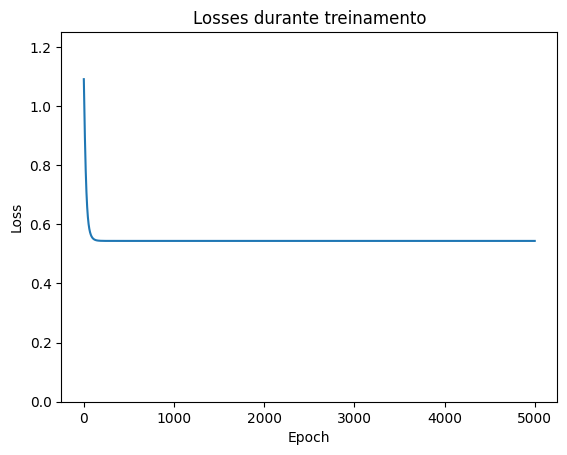

In [177]:
plt.plot(teste)
plt.title('Losses durante treinamento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.25)

Vamos fazer uma otimização de hiperparâmetros e visualizar a learning rate

Learning rate: 0.1
Tempo de execução: 50.76775789260864, loss: 0.5438565611839294
Learning rate: 0.01
Tempo de execução: 51.242624282836914, loss: 0.5438565611839294
Learning rate: 0.001
Tempo de execução: 50.18684005737305, loss: 0.6263332962989807
Learning rate: 0.0001
Tempo de execução: 50.23325514793396, loss: 1.873496413230896


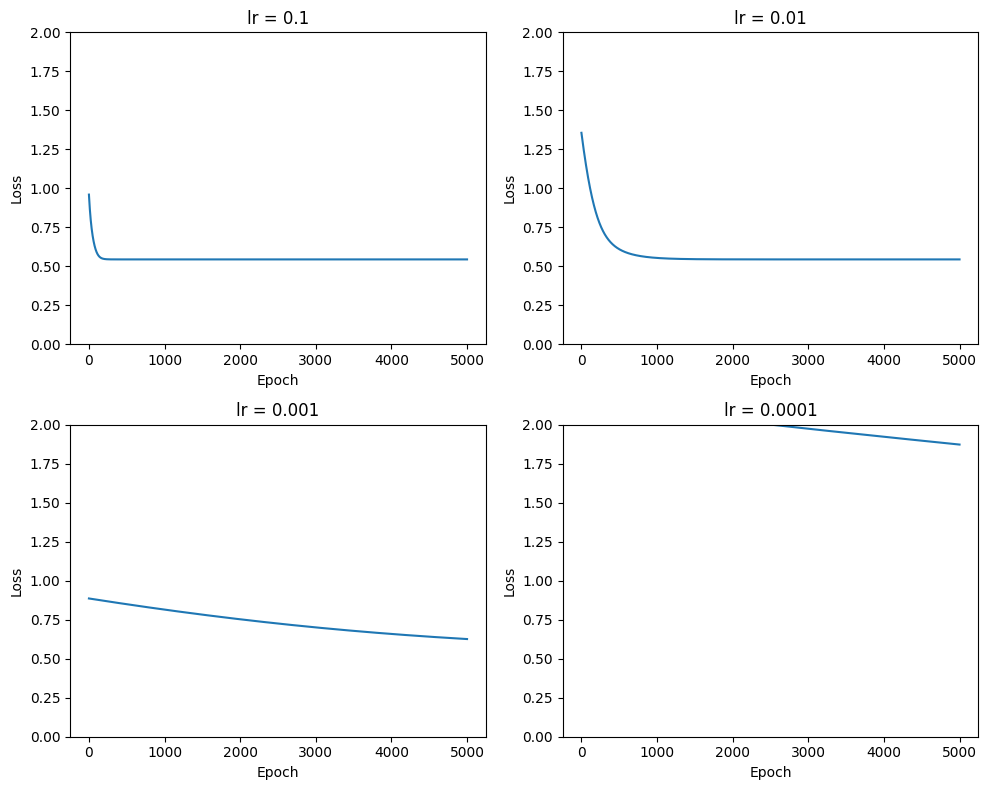

In [178]:
lrs = [0.1, 0.01, 0.001, 0.0001]

data = {}

for lr in lrs:
    data[lr] = model_train(lr, 5000, visible_epochs = False)

fig, axs = plt.subplots(2,2, figsize=(10,8))

# Itera sobre os quadrantes e as taxas de aprendizado
for ax, (lr, values) in zip(axs.flat, data.items()):
    ax.plot(values)
    ax.set_title(f'lr = {lr}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')  # Rótulo para o eixo y
    ax.set_ylim(0, 2)

# Ajusta o layout para que os subplots não se sobreponham
plt.tight_layout()

# Mostra a figura
plt.show()


## Testando o modelo
Vamos avaliar o modelo com os dados de teste, primeiro calculando a taxa de acerto.

In [179]:
losses = []
accuracies = []
epochs = 5000
learning_rate = 0.01

loss_fnc = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.optimizers.SGD(learning_rate = learning_rate)

pesos = tf.Variable(tf.random.normal([tamanho, 1], name = 'pesos'))
vies = tf.Variable(tf.random.normal([1], name = 'vies'))

def neuronio(x):
  return tf.sigmoid(tf.add(tf.matmul(x, pesos), vies))

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    resultado = neuronio(x_treino)
    loss = loss_fnc(y_treino, resultado)

    gradientes = tape.gradient(loss, [pesos, vies])
    optimizer.apply_gradients(zip(gradientes, [pesos, vies]))

    # Taxa de acerto
    teste = neuronio(x_teste)
    accuracy = np.mean(y_teste.numpy() == (teste.numpy() > 0.5)*1)

    losses.append(loss.numpy())
    accuracies.append(accuracy)

    if (epoch+1) % 500 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss.numpy()}, accuracy: {accuracy}')




Epoch: 500, loss: 0.8506014943122864, accuracy: 0.4926095135716205
Epoch: 1000, loss: 0.6247125864028931, accuracy: 0.5047030368180596
Epoch: 1500, loss: 0.5651642084121704, accuracy: 0.5047030368180596
Epoch: 2000, loss: 0.5489643216133118, accuracy: 0.5047030368180596
Epoch: 2500, loss: 0.5450558662414551, accuracy: 0.5047030368180596
Epoch: 3000, loss: 0.5441416501998901, accuracy: 0.5047030368180596
Epoch: 3500, loss: 0.5439253449440002, accuracy: 0.5047030368180596
Epoch: 4000, loss: 0.5438733100891113, accuracy: 0.5047030368180596
Epoch: 4500, loss: 0.5438606142997742, accuracy: 0.5047030368180596
Epoch: 5000, loss: 0.5438573956489563, accuracy: 0.5047030368180596


In [180]:
print(f'Menor loss: {min(losses)}')
print(f'Maior taxa de acerto: {max(accuracies)}')

Menor loss: 0.5438573956489563
Maior taxa de acerto: 0.5047030368180596


Visualizando os gráficos

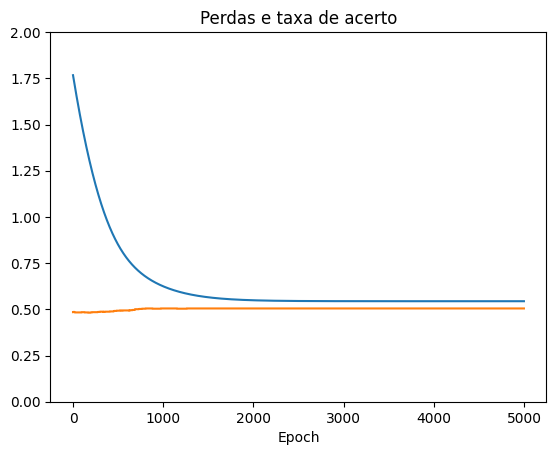

In [181]:
plt.plot(losses)
plt.plot(accuracies)
plt.title('Perdas e taxa de acerto')
plt.xlabel('Epoch')
plt.ylim(0,2)
plt.show()

# Camada oculta
Em busca de uma eficiencia melhor da nossa rede neural, e uma melhoria nos resultados, podemos tentar colocar mais uma camada de processamento.

Para isso, temos que nos atentar às estruturas das matrizes na geração dos pesos e vieses



In [182]:
def gerar_pesos_vieses(size_anterior, n_neuronios):
  pesos = tf.Variable(tf.random.normal([size_anterior, n_neuronios]))
  vieses = tf.Variable(tf.random.normal([n_neuronios]))

  return pesos, vieses

Agora, geramos os pesos e nossos modelos

In [183]:
size_entrada = x_treino.shape[1]

pesos1, vies1 = gerar_pesos_vieses(size_entrada, 3)
pesos2, vies2 = gerar_pesos_vieses(3, 1)

optimizer = tf.optimizers.SGD(learning_rate = 0.01)

epochs = 1000
losses = []
accuracies = []

def neuronio(x, pesos, vies):
  return tf.sigmoid(tf.add(tf.matmul(x,pesos), vies))

tic = time.time()
for epoch in range(epochs):
  with tf.GradientTape() as tape:
    resultado = neuronio(x_treino, pesos1, vies1)
    resultado = neuronio(resultado, pesos2, vies2)
    loss = calculo_perda(y_treino, resultado)

    predict = neuronio(x_teste, pesos1, vies1)
    predict = neuronio(predict, pesos2, vies2)
    accuracy = np.mean(y_teste.numpy() == (predict.numpy() > 0.5)*1)

    losses.append(loss)
    accuracies.append(accuracy)

    gradientes = tape.gradient(loss, [pesos1, vies1, pesos2, vies2])
    optimizer.apply_gradients(zip(gradientes, [pesos1, vies1, pesos2, vies2]))

    if epoch % 100 == 0:
      print(f'Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}')

tac = time.time()
tempo = tac-tic

print(f'Tempo total de execução {tempo}s')

Epoch: 0, loss: 0.9260503053665161, accuracy: 0.5302338081160978
Epoch: 100, loss: 0.870952308177948, accuracy: 0.5302338081160978
Epoch: 200, loss: 0.8309295177459717, accuracy: 0.5302338081160978
Epoch: 300, loss: 0.8003239035606384, accuracy: 0.5302338081160978
Epoch: 400, loss: 0.7757757306098938, accuracy: 0.5302338081160978
Epoch: 500, loss: 0.7553321123123169, accuracy: 0.5302338081160978
Epoch: 600, loss: 0.7378409504890442, accuracy: 0.5302338081160978
Epoch: 700, loss: 0.7225929498672485, accuracy: 0.5302338081160978
Epoch: 800, loss: 0.7091246843338013, accuracy: 0.5302338081160978
Epoch: 900, loss: 0.6971139907836914, accuracy: 0.5315775329212578
Tempo total de execução 14.102046251296997s


In [184]:
print(f'Menor custo: {min(losses)}')
print(f'Maior acurácia: {max(accuracies)}')

Menor custo: 0.6864254474639893
Maior acurácia: 0.5342649825315775


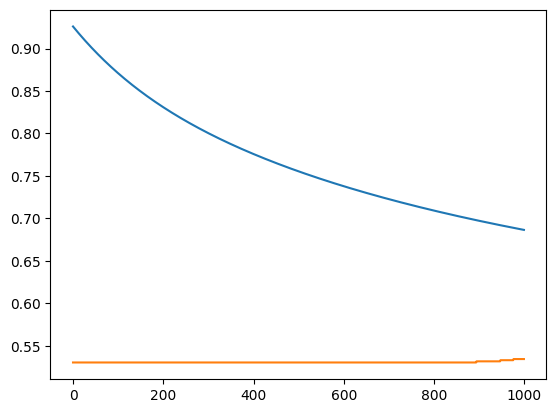

In [185]:
plt.plot(losses)
plt.plot(accuracies)
plt.show()

# Múltiplas Camadas Ocultas
Vamos começar uma estrutura de Depp Learning com várias camadas de processamento

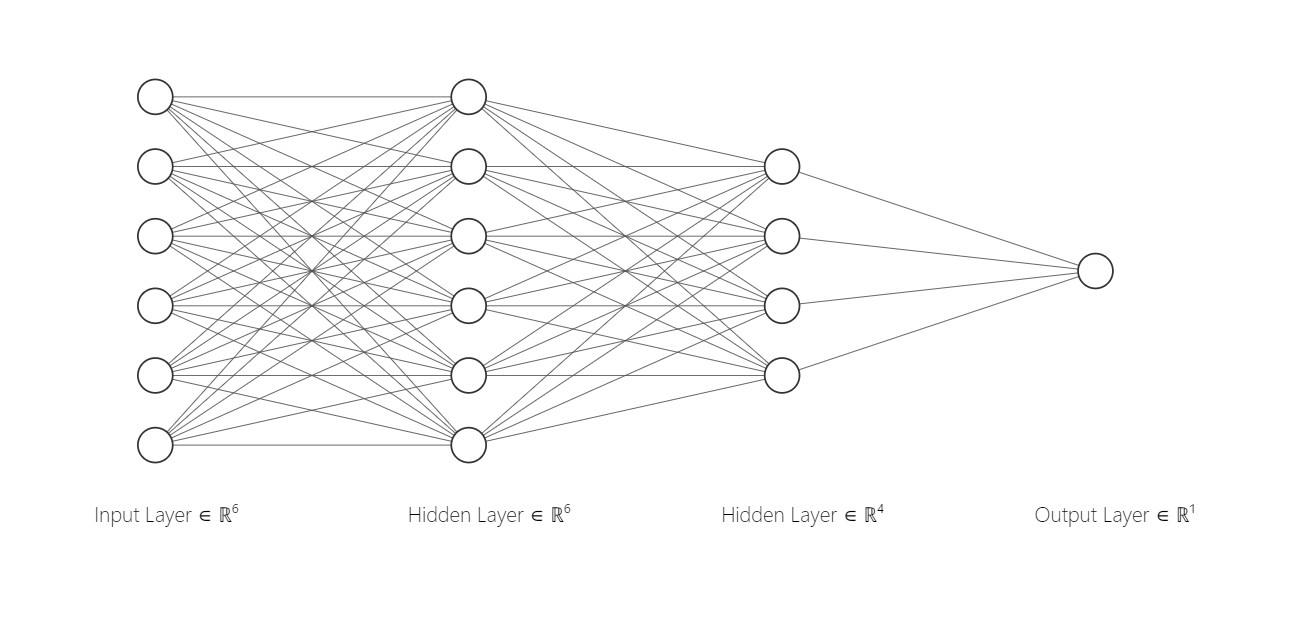

In [186]:
def pesos_vieses_deep(size_entrada, size_camada1, size_camada2):

  pesos1 = tf.Variable(tf.random.normal([size_entrada, size_camada1]))
  vies1 = tf.Variable(tf.random.normal([size_camada1]))

  pesos2 = tf.Variable(tf.random.normal([size_camada1, size_camada2]))
  vies2 = tf.Variable(tf.random.normal([size_camada2]))

  pesos_saida = tf.Variable(tf.random.normal([size_camada2, 1]))
  vies_saida = tf.Variable(tf.random.normal([1]))

  return pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida

In [187]:
pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida = pesos_vieses_deep(size_entrada, 6, 4)

In [188]:
optimizer = tf.optimizers.SGD(learning_rate = 0.01)
epochs = 1000

losses = []
accuracies = []

def neuronio(x, pesos, vies):
  return tf.sigmoid(tf.add(tf.matmul(x, pesos), vies))

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    resultado = neuronio(x_treino, pesos1, vies1) #Camada de input
    resultado = neuronio(resultado, pesos2, vies2) #Camada intermediária
    resultado = neuronio(resultado, pesos_saida, vies_saida) # Camada final gerando saída
    loss = calculo_perda(y_treino, resultado)

  losses.append(loss.numpy())

  predict = neuronio(x_teste, pesos1, vies1)
  predict = neuronio(predict, pesos2, vies2)
  predict = neuronio(predict, pesos_saida, vies_saida)

  accuracy = np.mean(y_teste.numpy() == (predict.numpy()>0.5)*1)
  accuracies.append(accuracy)

  gradientes = tape.gradient(loss, [pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida])

  optimizer.apply_gradients(zip(gradientes, [pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida]))

print(f'Foram concluídas {epoch+1} epochs.\n Loss: {loss.numpy()}')
print(f'Acurácia: {accuracy}')


Foram concluídas 1000 epochs.
 Loss: 0.6378583312034607
Acurácia: 0.5154528352593389


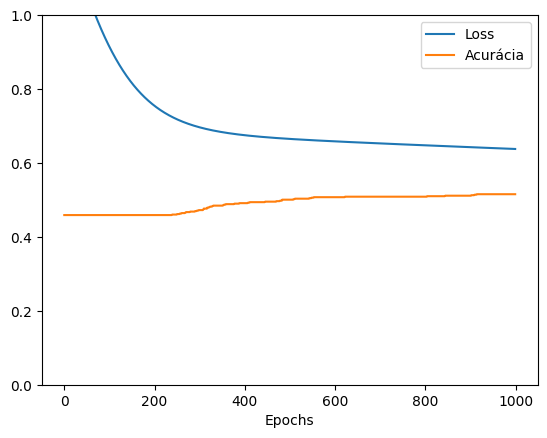

In [189]:
plt.plot(losses)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylim(0,1)
plt.legend(['Loss', 'Acurácia'])
plt.show()

Podemos fazer outra função de ativação. Utilizaremos a ReLU:

$$
f(x) = x^{+} = \max(0,x) = \frac{x + |x|}{2} =
\begin{cases}
    x & \text{se } x > 0, \\
    0 & \text{caso contrário}.
\end{cases}
$$

Manteremos ela apenas nas camadas intermediárias, tendo em vista que nosso critério de análise de acerto está baseado na sigmoid.


In [190]:
variaveis = pesos_vieses_deep(6,6,4)
pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida = variaveis

optimizer = tf.optimizers.SGD(learning_rate = 0.01)
epochs = 1000

losses = []
accuracies = []

def neuronio(x, pesos, vies):
  return tf.add(tf.matmul(x, pesos), vies)

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    resultado = tf.nn.relu(neuronio(x_treino, pesos1, vies1)) #Camada de input
    resultado = tf.nn.relu(neuronio(resultado, pesos2, vies2)) #Camada intermediária
    resultado = tf.sigmoid(neuronio(resultado, pesos_saida, vies_saida)) # Camada final gerando saída
    loss = calculo_perda(y_treino, resultado)

  losses.append(loss.numpy())

  predict = neuronio(x_teste, pesos1, vies1)
  predict = neuronio(predict, pesos2, vies2)
  predict = neuronio(predict, pesos_saida, vies_saida)

  accuracy = np.mean(y_teste.numpy() == (predict.numpy()>0.5)*1)
  accuracies.append(accuracy)

  gradientes = tape.gradient(loss, [pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida])

  optimizer.apply_gradients(zip(gradientes, [pesos1, vies1, pesos2, vies2, pesos_saida, vies_saida]))

print(f'Foram concluídas {epoch+1} epochs.\n Loss: {loss.numpy()}')
print(f'Acurácia: {accuracy}')


Foram concluídas 1000 epochs.
 Loss: 0.5553252696990967
Acurácia: 0.5060467616232196


In [191]:
print(f'Menor loss com ReLU {min(losses)}')
print(f'Maior acurárcia com ReLU {max(accuracies)}')

Menor loss com ReLU 0.5553252696990967
Maior acurárcia com ReLU 0.5060467616232196


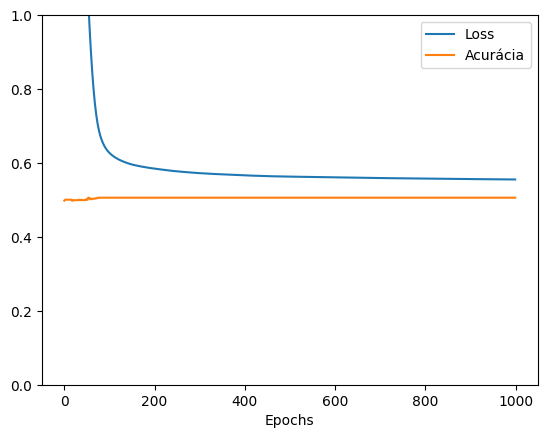

In [192]:
plt.plot(losses)
plt.plot(accuracies)
plt.xlabel('Epochs')
plt.ylim(0,1)
plt.legend(['Loss', 'Acurácia'])
plt.show()